In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random
import scipy.signal
from skimage.restoration import denoise_tv_bregman
from skimage import restoration
import skimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2


In [2]:
random.seed(200)

tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(False) # Start with XLA disabled.

def load_data():
  result = tfds.load('cifar10', batch_size = -1)
  (x_train, y_train) = result['train']['image'],result['train']['label']
  (x_test, y_test) = result['test']['image'],result['test']['label']

  x_train = x_train.numpy().astype('float32') / 256
  x_test = x_test.numpy().astype('float32') / 256

  # Convert class vectors to binary class matrices.
  y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
  return ((x_train, y_train), (x_test, y_test))

(x_train, y_train), (x_test, y_test) = load_data()


img = Image.new('RGB', (32, 32), (255, 255, 255))
draw = ImageDraw.Draw(img)
for y in range(5, 91, 4):
    draw.line((32, y, 0, y), (0, 0, 0), 2)

def struct_noise(image):
   im = Image.fromarray((image * 255).astype(np.uint8)) 
   noisyimage = Image.blend(im, img, 0.10)
   return noisyimage




#test 1: train0 test0 = base splits

#test 2: train0 test75
a,b,an,bn = train_test_split(x_test, y_test, test_size=0.25, random_state=44)
a0 = np.empty_like(a)
y2 = np.empty_like(an)
ytv2 = np.empty_like(an)
atv = np.empty_like(a)
for j in range(len(a)):
    a0[j] = struct_noise(a[j])
    atv[j] = skimage.restoration.denoise_tv_bregman(struct_noise(a[j]))
    y2[j] = an[j]
    ytv2[j] = an[j]
a0 = np.concatenate((a0,b))
atv = np.concatenate((atv,b))
y2 = np.concatenate((y2,bn))
ytv2 = np.concatenate((ytv2, bn))

#test 3: train0 test50
c,d,cn,dn = train_test_split(x_test, y_test, test_size=0.50, random_state=44)
c0 = np.empty_like(c)
ctv = np.empty_like(c)
y3 = np.empty_like(cn)
ytv3 = np.empty_like(cn)
for j in range(len(c)):
    c0[j] = struct_noise(c[j])
    ctv[j] = skimage.restoration.denoise_tv_bregman(struct_noise(c[j]))
    y3[j] = cn[j]
    ytv3[j] = cn[j]
c0 = np.concatenate((c0,d))
ctv = np.concatenate((ctv,d))
y3 = np.concatenate((y3,dn))
ytv3 = np.concatenate((ytv3, dn))

#test 4: train0 test25
e,f,en,fn = train_test_split(x_test,y_test, test_size=0.75, random_state=44)
e0 = np.empty_like(e)
etv = np.empty_like(e)
y4 = np.empty_like(en)
ytv4 = np.empty_like(en)
for j in range(len(e)):
    e0[j] = struct_noise(e[j])
    etv[j] = skimage.restoration.denoise_tv_bregman(struct_noise(e[j]))
    y4[j] = en[j]
    ytv4[j] = en[j]
e0 = np.concatenate((e0,f))
etv = np.concatenate((etv,f))
y4 = np.concatenate((y4,fn))
ytv4 = np.concatenate((ytv4, fn))

#test 5: train0 test100
g0 = np.empty_like(x_test)
gtv = np.empty_like(x_test)
for j in range(len(x_test)):
    g0[j] = struct_noise(x_test[j])
    gtv[j] = skimage.restoration.denoise_tv_bregman(struct_noise(x_test[j]))

In [3]:
def generate_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
  ])

model = generate_model()

In [4]:
def compile_model(model):
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model

model = compile_model(model)

def train_model(model, x_train, y_train, x_test, y_test, epochs=25):
  model.fit(x_train, y_train, batch_size=256, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

train_model(model, x_train,y_train, x_test,y_test)

Epoch 1/25
196/196 [==============================] - 32s 158ms/step - loss: 2.0135 - accuracy: 0.2522 - val_loss: 1.6908 - val_accuracy: 0.3902
Epoch 2/25
196/196 [==============================] - 29s 150ms/step - loss: 1.6608 - accuracy: 0.3919 - val_loss: 1.5338 - val_accuracy: 0.4423
Epoch 3/25
196/196 [==============================] - 30s 153ms/step - loss: 1.5476 - accuracy: 0.4341 - val_loss: 1.4602 - val_accuracy: 0.4739
Epoch 4/25
196/196 [==============================] - 29s 148ms/step - loss: 1.4697 - accuracy: 0.4649 - val_loss: 1.3836 - val_accuracy: 0.5057
Epoch 5/25
196/196 [==============================] - 30s 151ms/step - loss: 1.4157 - accuracy: 0.4884 - val_loss: 1.3252 - val_accuracy: 0.5269
Epoch 6/25
196/196 [==============================] - 31s 156ms/step - loss: 1.3711 - accuracy: 0.5042 - val_loss: 1.2855 - val_accuracy: 0.5438
Epoch 7/25
196/196 [==============================] - 29s 149ms/step - loss: 1.3265 - accuracy: 0.5241 - val_loss: 1.2544 - val_ac

In [5]:
scores_t1 = model.evaluate(x_test, y_test, verbose=1)
print('Benchmark Test loss:', scores_t1[0])
print('Benchmark Test accuracy:', scores_t1[1])

base_scores_t2 = model.evaluate(a0, y2, verbose=1)
print('B75 Test loss:', base_scores_t2[0])
print('B75 Test accuracy:', base_scores_t2[1])

tv_scores_t2 = model.evaluate(atv, ytv2, verbose=1)
print('T75 Test loss:', tv_scores_t2[0])
print('T75 Test accuracy:', tv_scores_t2[1])

base_scores_t3 = model.evaluate(c0, y3, verbose=1)
print('B50 Test loss:', base_scores_t3[0])
print('B50 Test accuracy:', base_scores_t3[1])

tv_scores_t3 = model.evaluate(ctv, ytv3, verbose=1)
print('T50 Test loss:', tv_scores_t3[0])
print('T50 Test accuracy:', tv_scores_t3[1])

base_scores_t4 = model.evaluate(e0, y4, verbose=1)
print('B25 Test loss:', base_scores_t4[0])
print('B25 Test accuracy:', base_scores_t4[1])

tv_scores_t4 = model.evaluate(etv, ytv4, verbose=1)
print('T25 Test loss:', tv_scores_t4[0])
print('T25 Test accuracy:', tv_scores_t4[1])

base_scores_t5 = model.evaluate(g0, y_test, verbose=1)
print('B100 Test loss:', base_scores_t5[0])
print('B100 Test accuracy:', base_scores_t5[1])

tv_scores_t5 = model.evaluate(gtv, y_test, verbose=1)
print('T100 Test loss:', tv_scores_t5[0])
print('T100 Test accuracy:', tv_scores_t5[1])

313/313 [==============================] - 2s 8ms/step - loss: 0.9018 - accuracy: 0.6876
Benchmark Test loss: 0.9018446207046509
Benchmark Test accuracy: 0.6876000165939331
313/313 [==============================] - 2s 7ms/step - loss: 308.1857 - accuracy: 0.4313
B75 Test loss: 308.1856689453125
B75 Test accuracy: 0.43130001425743103
313/313 [==============================] - 2s 7ms/step - loss: 1.4787 - accuracy: 0.4716
T75 Test loss: 1.4787477254867554
T75 Test accuracy: 0.4715999960899353
313/313 [==============================] - 2s 7ms/step - loss: 205.0474 - accuracy: 0.5182
B50 Test loss: 205.04742431640625
B50 Test accuracy: 0.5181999802589417
313/313 [==============================] - 2s 7ms/step - loss: 1.2833 - accuracy: 0.5458
T50 Test loss: 1.2832996845245361
T50 Test accuracy: 0.545799970626831
313/313 [==============================] - 2s 7ms/step - loss: 105.5185 - accuracy: 0.5999
B25 Test loss: 105.51850891113281
B25 Test accuracy: 0.5999000072479248
313/313 [========

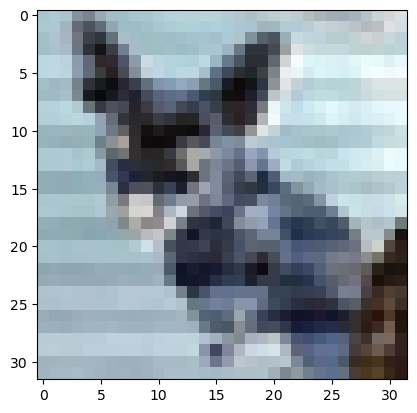

69.26436993306707


In [6]:
#plt.imshow((atv[0] * 255).astype(np.uint8))
plt.imshow((a0[0] * 255).astype(np.uint8))
#plt.imshow((a[0] * 255).astype(np.uint8))
plt.show()
psnr2 = cv2.PSNR(a[0], atv[0])
print(psnr2)